In [1]:
import gc
import pywt
import numpy as np
import tensorflow as tf
from scipy.optimize import curve_fit
from tensorflow import keras
from matplotlib import pyplot as plt 
from scipy.stats import mode
from sklearn.cross_validation import train_test_split
from statsmodels.robust import mad

#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#set_session(tf.Session(config=config))

In [2]:
def my_metric(y_true, y_pred):
    y_true, y_pred = tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1])
    er = y_true - y_pred
    mask_n, mask_p = (er<=0), (er>0)
    er_n, er_p = tf.boolean_mask(er, mask_n), tf.boolean_mask(er, mask_p)
    score_n = tf.exp(-tf.log(0.5)*er_n/5)
    score_p = tf.exp(tf.log(0.5)*er_p/20)
    score = tf.concat([score_n, score_p], 0)
    score = tf.reduce_mean(score)*100
    return score

def metric_numpy(y_true, y_pred):
    y_true, y_pred = y_true.ravel(), y_pred.ravel()
    er = y_true - y_pred
    mask_n, mask_p = (er<=0), (er>0)
    er_n, er_p = er[mask_n], er[mask_p]
    score_n = np.exp(-np.log(0.5)*er_n/5)
    score_p = np.exp(np.log(0.5)*er_p/20)
    score = np.concatenate([score_n, score_p], 0)
    score = np.mean(score)*100
    return score

def my_loss(y_true, y_pred):
    y_true, y_pred = tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1])
    diff = tf.abs(y_true - y_pred)
    loss = tf.pow(diff, 3)
    return tf.reduce_mean(loss)

class Metric_Callback(keras.callbacks.Callback):
    def __init__(self, train_data, valid_data, t_l, v_l):
        self.train_data = train_data
        self.valid_data = valid_data
        self.t_l, self.v_l = t_l, v_l
        
    def on_epoch_end(self, batch, logs={}):
        y_pred = self.model.predict(self.train_data[0]).ravel() * self.t_l
        y_true = self.train_data[1] * self.t_l
        print("Train score %.4f"%metric_numpy(y_true, y_pred))
        
        y_pred = self.model.predict(self.valid_data[0]).ravel() * self.v_l
        y_true = self.valid_data[1] * self.v_l
        print("Valid score %.4f"%metric_numpy(y_true, y_pred))

def wavelet_smooth(data, wavelet="db4", level=4, m=1, n=4, plot=False):
    coeff = pywt.wavedec(data,wavelet,mode='sym', level=level)

    for i in range(m, n+1):
        length = len(coeff[i])
        threshold = np.sqrt(2*np.log(length))
        coeff[i] = pywt.threshold(coeff[i], value=threshold, mode="soft")

    denoised_data = pywt.waverec(coeff,wavelet,mode="sym")
    if plot:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(111)
        ax.plot(data)
        ax.plot(denoised_data)
        plt.show()
    return denoised_data

In [3]:
def curve(x, b):
    return -5*x+b
curve_numpy = np.vectorize(curve)

In [4]:
train = np.load("Output/01_train_a.npz", mmap_mode='r')
valid = np.load("Output/02_test_a.npz", mmap_mode="r")

In [5]:
gc.collect()
train_data, train_label = train["data"], train["label"]
indices = np.random.permutation(train_label.shape[0])
train_features, train_S, train_y = train_data[indices], train_label[indices, 0], train_label[indices,-1]

valid_data, valid_label = valid["data"], valid["label"]
valid_features, valid_S, valid_y = valid_data, valid_label[:, 0], valid_label[:,-1]

In [6]:
#func = lambda x:wavelet_smooth(x)
func = np.fft.fft
train_X = np.zeros((len(train_y), 25600, 1))
valid_X = np.zeros((len(valid_y), 25600, 1))
for idx, elem in enumerate(train_features):
    train_X[idx, :, 0] = func(elem[:, 0])
    #features_modified[idx, :, 1] = func(elem[:, 1])
    #features_modified[idx, :, 2] = func(elem[:, 2])
for idx, elem in enumerate(valid_features):
    valid_X[idx, :, 0] = func(elem[:, 0])

/home/shuzhilian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
/home/shuzhilian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


In [24]:
def build_model(shape_1, shape_2):
    input_x = keras.layers.Input(shape=shape_1, name="X")
    used_time = keras.layers.Input(shape=shape_2, name="S")
    x = tf.layers.BatchNormalization(axis=-1)(input_x)
    
    x = tf.layers.Conv1D(filters=16, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.Conv1D(filters=16, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.MaxPooling1D(pool_size=4, strides=4)(x)
    x = tf.layers.Dropout(0.5)(x)
    
    x = tf.layers.Conv1D(filters=16, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.Conv1D(filters=16, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.MaxPooling1D(pool_size=4, strides=4)(x)
    x = tf.layers.Dropout(0.5)(x)
    
    x = tf.layers.Conv1D(filters=32, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.Conv1D(filters=32, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.MaxPooling1D(pool_size=4, strides=4)(x)
    x = tf.layers.Dropout(0.5)(x)
    
    x = tf.layers.Conv1D(filters=32, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.Conv1D(filters=32, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.MaxPooling1D(pool_size=4, strides=4)(x)
    x = tf.layers.Dropout(0.5)(x)
    
    x = tf.layers.Conv1D(filters=16, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.Conv1D(filters=16, kernel_size=7, strides=1, activation=None, padding="same")(x)
    x = tf.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation(activation=tf.nn.relu)(x)
    x = tf.layers.MaxPooling1D(pool_size=4, strides=4)(x)
    x = tf.layers.Dropout(0.5)(x)
    
    x = tf.layers.Flatten()(x)
    x = tf.layers.Dense(1600, activation=tf.nn.relu)(x)
    x = tf.layers.Dense(800, activation=tf.nn.relu)(x)
    x = tf.layers.Dense(200, activation=tf.nn.relu)(x)
    #x = keras.layers.Concatenate(axis=-1)([x,used_time])
    x = tf.layers.Dense(50, activation=tf.nn.relu)(x)
    x = tf.layers.Dense(20, activation=tf.nn.relu)(x)
    y = tf.layers.Dense(1, activation=None)(x)
    
    model = keras.models.Model(inputs=[input_x, used_time], outputs=y, name="base")
    return model

In [25]:
model = build_model((25600, 1), (1,))

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
losses = tf.losses.mean_squared_error
#losses = my_loss
model.compile(optimizer=optimizer, loss=losses, metrics=[my_metric])

In [28]:
#my_callback = Metric_Callback([[train_X_1, train_X_2], train_y], 
#                              [[test_X_1, test_X_2], test_y, 
#                              train_y[:, 1], test_y[:, 1])

In [29]:
#model.load_weights("Fourier_Outlier.weights")
history = model.fit([train_X, train_S], train_y, epochs=32, batch_size=64, 
                    validation_data=[[valid_X, valid_S], valid_y])

Train on 7882 samples, validate on 3000 samples
Epoch 1/32
7882/7882 [==============================] - 10s 1ms/step - loss: 5555.2547 - my_metric: 18.1228 - val_loss: 5602.2275 - val_my_metric: 32.0815
Epoch 2/32
7882/7882 [==============================] - 8s 1ms/step - loss: 2180.1284 - my_metric: 25.6193 - val_loss: 5375.5801 - val_my_metric: 30.2604
Epoch 3/32
7882/7882 [==============================] - 8s 1ms/step - loss: 1445.7232 - my_metric: 31.1280 - val_loss: 5819.1294 - val_my_metric: 30.0593
Epoch 4/32
7882/7882 [==============================] - 8s 999us/step - loss: 1025.4745 - my_metric: 35.7601 - val_loss: 5256.9325 - val_my_metric: 21.0933
Epoch 5/32
7882/7882 [==============================] - 8s 993us/step - loss: 813.6828 - my_metric: 38.6228 - val_loss: 5186.9810 - val_my_metric: 23.6750
Epoch 6/32
7882/7882 [==============================] - 8s 1ms/step - loss: 775.2359 - my_metric: 38.4624 - val_loss: 4902.1560 - val_my_metric: 13.7582
Epoch 7/32
7882/7882 [===

In [35]:
#model.save_weights("xx.weights")

In [30]:
preds = model.predict([valid_X,valid_S])
x = list()
for i in range(10):
    x += [i]*60

100.0 [190.]
[110.39806279]


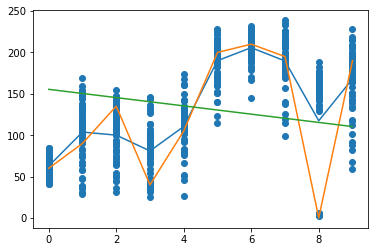

129.0 [150.]
[126.99026771]


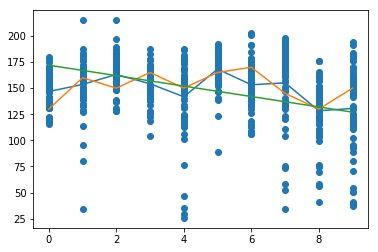

63.5 [80.]
[69.31659586]


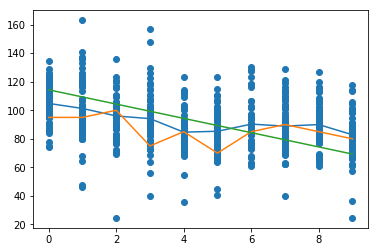

91.5 [95.]
[90.41562617]


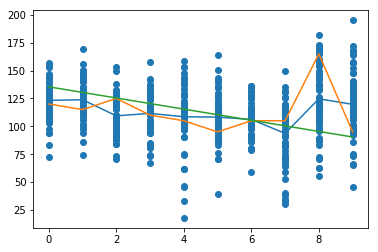

32.5 [30.]
[46.59011717]


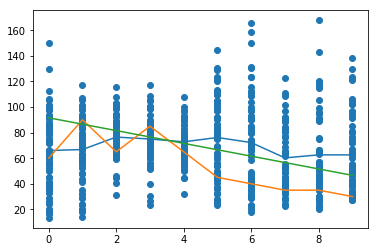

In [31]:
preds = preds.reshape(5, -1)
for pred in preds:
    plt.scatter(x, pred)
    data = pred.reshape(-1, 60)
    mean_val = data.mean(axis=-1)
    data = data//5
    mode_val = mode(data, axis=-1)[0]*5
    mode_res = (mode_val - np.array([[45],[40],[35],[30],[25],[20],[15],[10],[5],[0]])).mean()
    print(mode_res,mode_val[-1])
    b = curve_fit(curve, x, pred)[0]
    y = [curve(i, b) for i in x]
    print(y[-1])
    plt.plot(mean_val)
    plt.plot(mode_val)
    plt.plot(x,y)
    plt.show()

In [35]:
(mode_val - np.array([[45],[40],[35],[30],[25],[20],[15],[10],[5],[0]])).mean()

48.5

In [27]:
for pred in preds:
    print(curve_fit(curve, x, pred)[0])

[120.42187545]
[119.4981322]
[117.48767144]
[120.10352607]
[117.55310917]


In [ ]:
res = (test_label[:, 0:1]/(1-preds))*preds-test_label[:,1:2]
res = res.reshape(5, 10, 60)
res = res[:, -1, :]

In [ ]:
temp = res//10*10

In [ ]:
temp

In [ ]:
modes = mode(temp, axis=-1)[0]

In [ ]:
for i in range(5):
    print(res[i][(temp[i]>=modes[i]) & (temp[i]<(modes[i]+10))].mean())

In [ ]:
(temp[i]>=modes[i]) & (temp[i]<(modes[i]+10))

In [ ]:
a = tf.Variable([1,2,3,4])
mask = a > 2
b = tf.boolean_mask(a,mask)
plus = b+1

In [ ]:
sess = tf.Session()

In [ ]:
sess.run(tf.global_variables_initializer())
sess.run(plus)

In [ ]:
sess.run(a)

In [ ]:
data_0 = features[160*0:160*2:2, :, 0].ravel()
data_1 = features[160*0:160*2:2, :, 1].ravel()
data_2 = features[160*0:160*2:2, :, 2].ravel()

In [ ]:
fig = plt.figure(figsize=(32,9))
ax = fig.add_subplot(111)
ax.plot(data_0)
plt.show()

In [21]:
valid_y

array([160, 155, 189, ..., 100, 130, 127])

In [32]:
y_true = np.array([43,47,21,15])
y_pred = np.array([])
metric_numpy(y_true, y_pred)

18.43150395042046

In [31]:
valid_S

array([ 80,  75, 130, ..., 110,  55,  80])